In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import solar_plotting

import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = Path("/g/data/er8/users/cd3022/solar_drought/REZ/")
files = list(data_dir.glob("*.nc"))
datasets = []

for file in files:
    region_name = file.stem[0:2]
    ds_reg = xr.open_dataset(file)
    ds_reg = ds_reg.expand_dims(region=[region_name])

    datasets.append(ds_reg)

ds = xr.concat(datasets, dim='region')

# Change times to AEST
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

# Remove missing time step
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Convert generation to capacity factor
rated_capacity = 219.656729124
ds = ds / rated_capacity

# # Clip dusk and dawn from each day
for var in ds.data_vars:
    for reg in ds.region:
        	ds[var].sel(region=reg)[:] = solar_plotting.clip_dusk_dawn(ds[var].sel(region=reg), n=6) # n=6 for 6 time steps, i.e. one hour clippled from each end

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


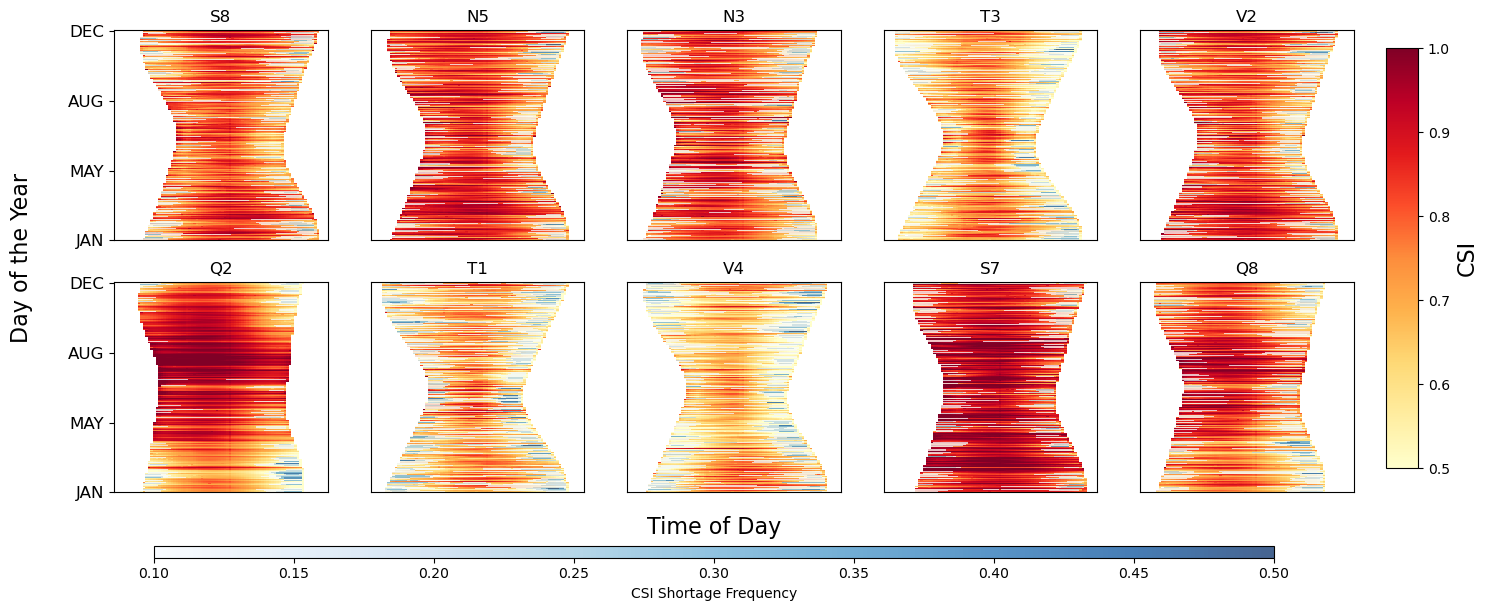

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.001, 0.7, 0.02])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )
cmap_droughts = plt.cm.Blues.copy()

cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')

im = None
im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual / ds.sel(region=reg).ideal).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)
    df = solar_plotting.day_time_df(data)
    df = df.drop(df.columns[49], axis=1)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(data, threshold = 0.2, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    # df_droughts[~df_droughts.isna()] = 1
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0.1, vmax=0.5, interpolation='none', zorder=1, alpha=0.75)

    # # Time of day ticks
    # xticks = np.linspace(0, len(df.columns) - 1, 5, dtype=int)
    # xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    # ax[row, col].set_xticks(xticks)
    # ax[row, col].set_xticklabels(xtick_labels, rotation=25, fontsize=12)
    ax[row, col].set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 4, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('CSI Shortage Frequency')
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

# plt.savefig(f'{fig_dir}/CSI-heatmap.png')
plt.show()

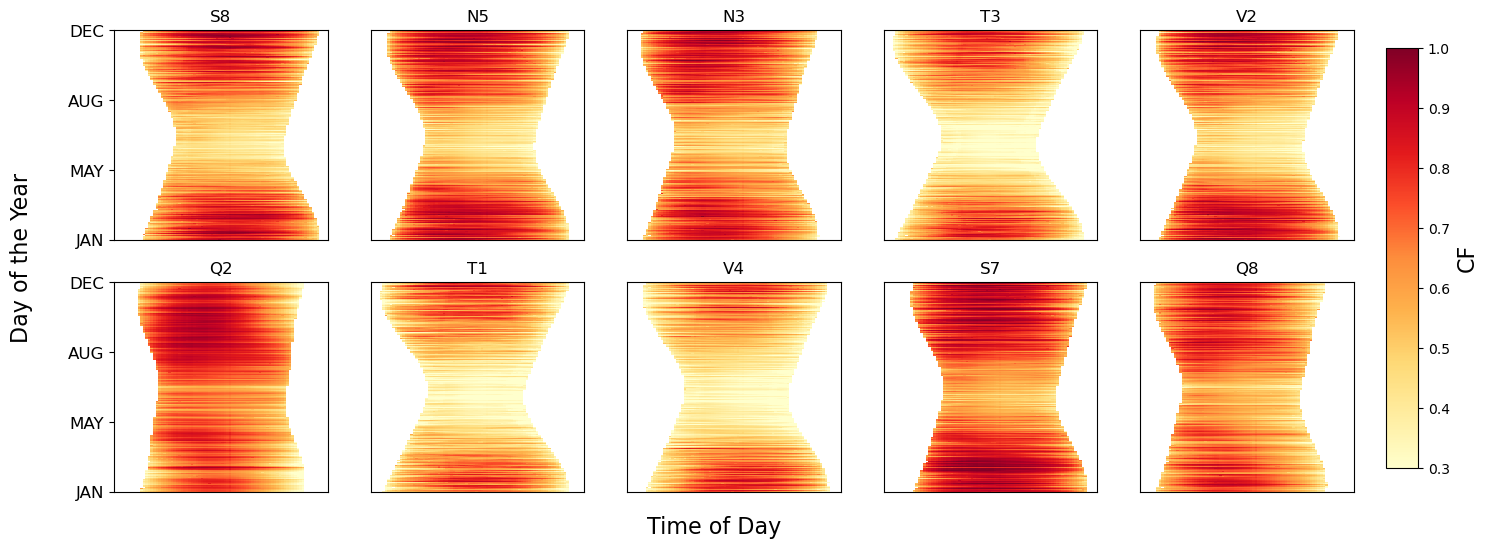

In [109]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )

cmap.set_bad(color='white')

im = None
im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)
    df = solar_plotting.day_time_df(data)
    df = df.drop(df.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.3, vmax=1, interpolation='none', zorder=0)

    ax[row, col].set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 4, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im, cax=cbar_ax).set_label('CF', fontsize=16)

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

# plt.savefig(f'{fig_dir}/CSI-heatmap.png')
plt.show()

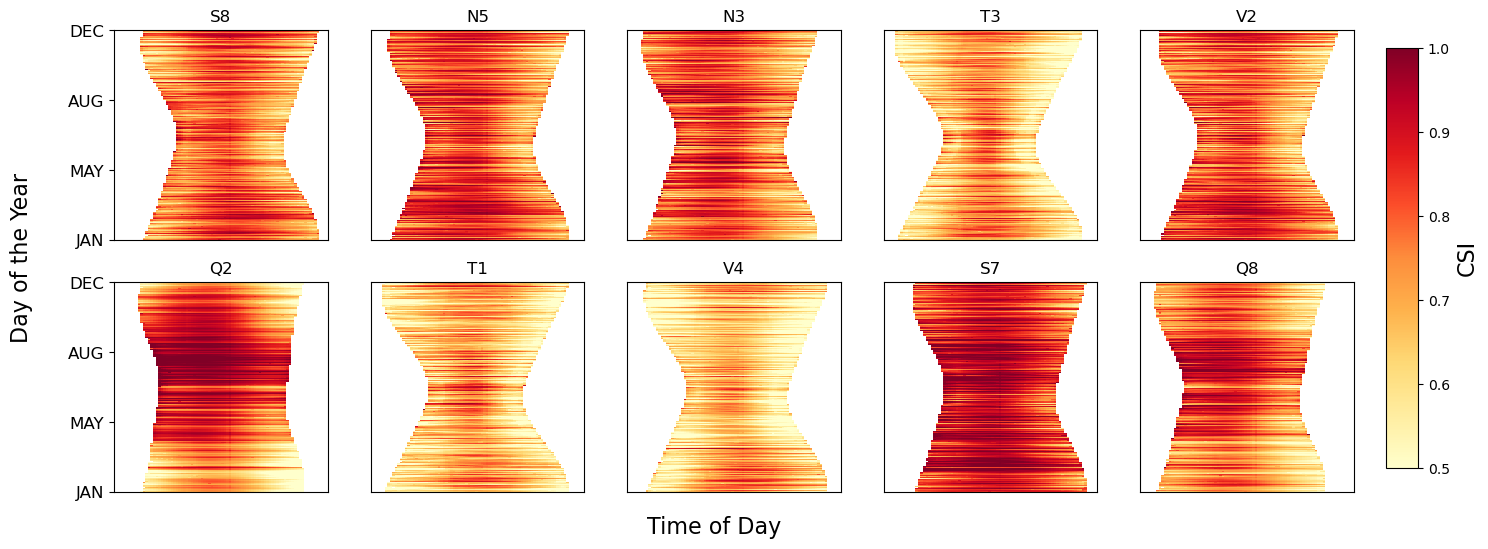

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )

cmap.set_bad(color='white')

im = None
im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual / ds.sel(region=reg).ideal).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)
    df = solar_plotting.day_time_df(data)
    df = df.drop(df.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)

    ax[row, col].set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 4, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=16)

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

# plt.savefig(f'{fig_dir}/CSI-heatmap.png')
plt.show()

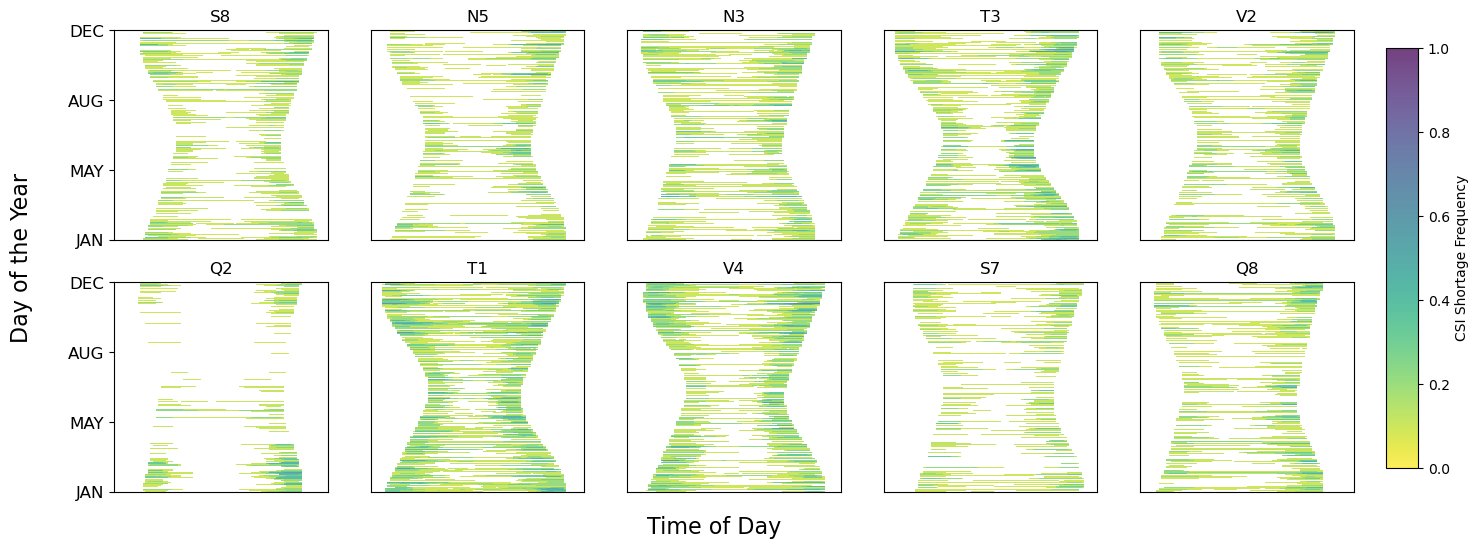

In [120]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# Create the colormaps
cmap_droughts = plt.cm.viridis_r.copy()

cmap_droughts.set_bad(color='white')

im_droughts = None

for idx, reg in enumerate(ds.region):

    data = (ds.sel(region=reg).actual / ds.sel(region=reg).ideal).copy()
    # data = xr.where(data == 0, np.nan, data)
    
    row, col = divmod(idx, 5)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(data, threshold = 0.25, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    # df_droughts[~df_droughts.isna()] = 1
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)

   
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower",
                                      cmap=cmap_droughts, vmin=0, vmax=1,
                                      interpolation='none', zorder=1, alpha=0.75)

    # # Time of day ticks
    # xticks = np.linspace(0, len(df.columns) - 1, 5, dtype=int)
    # xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    # ax[row, col].set_xticks(xticks)
    # ax[row, col].set_xticklabels(xtick_labels, rotation=25, fontsize=12)
    ax[row, col].set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 4, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg.data)

fig.colorbar(im_droughts, cax=cbar_ax, orientation='vertical').set_label('CSI Shortage Frequency')
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

# plt.savefig(f'{fig_dir}/CSI-heatmap.png')
plt.show()

# Solar Droughts

## Severity Threshold

For a given threshold of how severe a day needs to be to count as a drought, what is the frequency of events of different durations

### Constantly below threshold

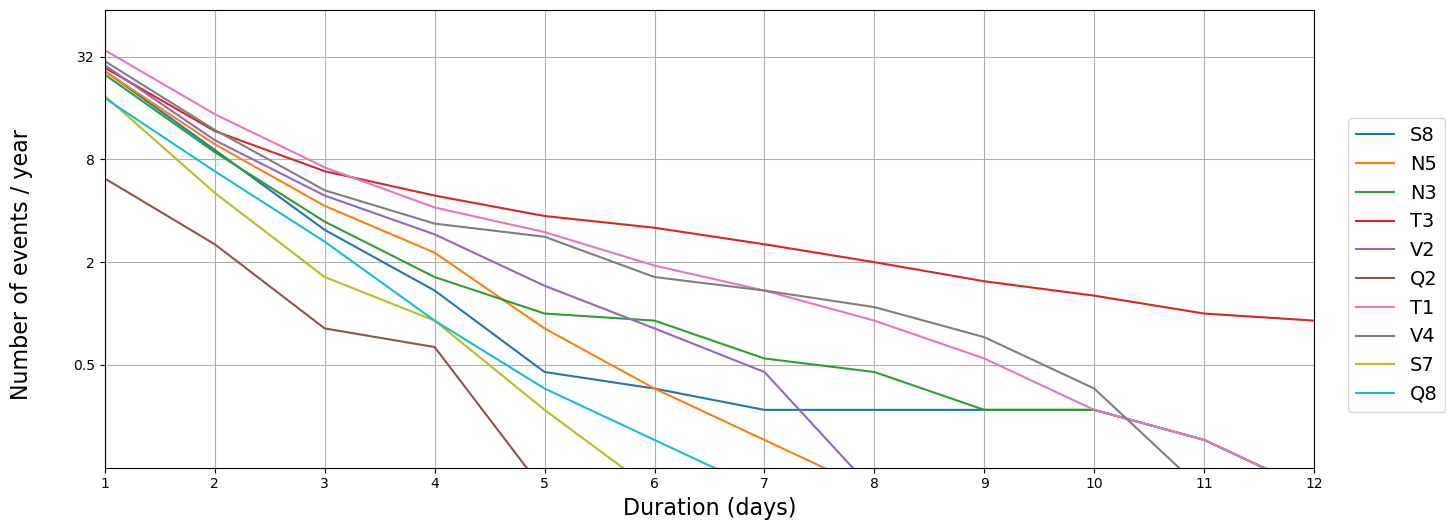

In [5]:
# CURRENTLY EACH DAY COUNTED AS A DROUGHT INDIVIDUALLY.
# SHOULD CHANGE TO A MEAN PERIOD DEFINITION, AS DONE FOR THE SUB-DAILY

from matplotlib.ticker import LogLocator, FuncFormatter, FormatStrFormatter

drought_lengths = np.linspace(6, 72, 23)

def format_ticks(val, _):
    if val < 1:
        return f"{val:.1f}"  # Show decimals like 0.5
    else:
        return f"{int(val)}"

fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    data = xr.where(data.isnull(), 0, data)

    threshold = 0.5 * data.mean()
    
    x, y = solar_plotting.daily_drought(
        data,
        threshold=threshold,
    )
    ax.plot(x, y, label=reg.data)
    ax.set_xlim(1,8)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    ax.set_ylim(0.125,60)
    ax.grid(True)
    ax.set_xlabel('Duration (days)', fontsize=16)
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_locator(LogLocator(base=2.0))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.set_yticks([0.5, 2, 8, 32])

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
fig.supylabel('Number of events / year', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=14)

In [170]:
# For log axis
from matplotlib.ticker import LogLocator, FuncFormatter, FormatStrFormatter

drought_lengths = np.linspace(6, 72, 23)

def format_ticks(val, _):
    if (val < 1) and (val >= 0.5):
        return f"{val:.1f}"  # Show decimals like 0.5
    elif (val < 0.5) and (val >= 0.25):
        return f"{val:.2f}"
    elif (val < 0.25) and (val >= 0.125):
        return f"{val:.3f}"
    else:
        return f"{int(val)}"

### Mean below threshold

Text(0.5, 1.0, 'Droughts below CF threshold')

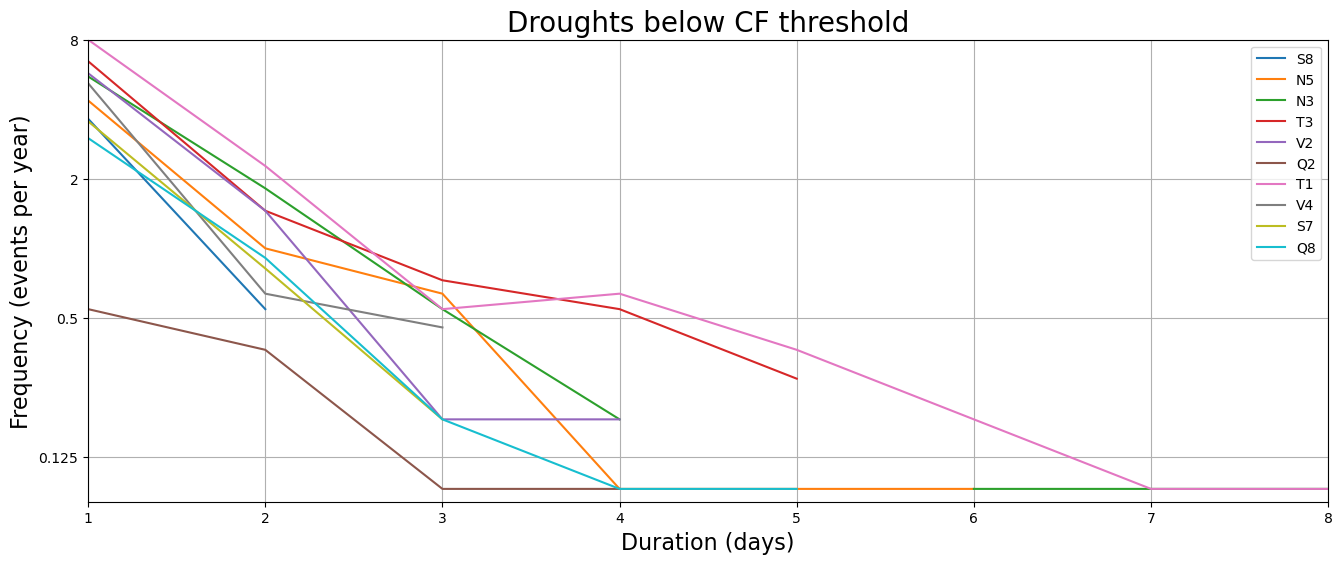

In [326]:
# Now should be using MBT, but might need some fixing

fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    data = xr.where(data.isnull(), 0, data)

    threshold = 0.25 * data.mean()
    
    dur, freq = solar_plotting.daily_mbt(
        data.resample(time='1D').mean(),
        threshold=threshold,
    )
    freq = [np.nan if x == 0 else x for x in freq]
    
    ax.plot(dur, freq, label=reg.data)
ax.grid(True)
ax.set_xlabel('Duration (days)', fontsize=16)
ax.set_ylabel('Frequency (events per year)', fontsize=16)

ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.set_yticks([0.125, 0.5, 2, 8])
ax.set_ylim(0.08,8)
ax.set_xlim(1,8)

ax.legend()
ax.set_title('Droughts below CF threshold', fontsize=20)

### Mean below threshold CSI

Text(0.5, 1.0, 'Droughts below CSI threshold')

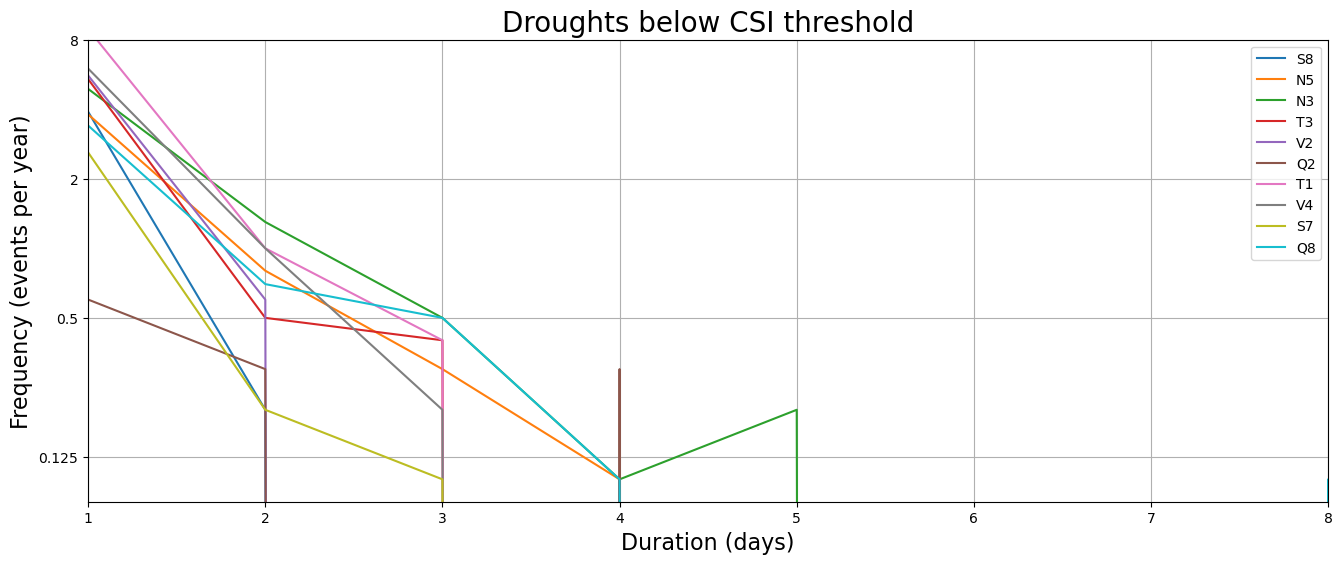

In [327]:
fig, ax = plt.subplots(figsize=(16,6))
for reg in ds.region:

    daily_actual = ds.actual.sel(region=reg).resample(time='1D').sum()
    daily_ideal = ds.ideal.sel(region=reg).resample(time='1D').sum()

    daily_CSI = daily_actual / daily_ideal
    
    dur, freq = solar_plotting.daily_mbt(
        daily_CSI.where(daily_CSI.time.dt.month.isin([5,6,7,8,9]), drop=True),
        threshold=0.3,
    )
    # freq = [np.nan if x == 0 else x for x in freq]
    ax.plot(dur, freq, label=reg.data)
        
ax.grid(True)
ax.set_xlabel('Duration (days)', fontsize=16)
ax.set_ylabel('Frequency (events per year)', fontsize=16)

ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.set_yticks([0.125, 0.5, 2, 8])
ax.set_ylim(0.08,8)
ax.set_xlim(1,8)

ax.legend()
ax.set_title('Droughts below CSI threshold', fontsize=20)

## Duration Threshold

For a given duration, what is the frequency of events that have different severities

### Load Duration Curves

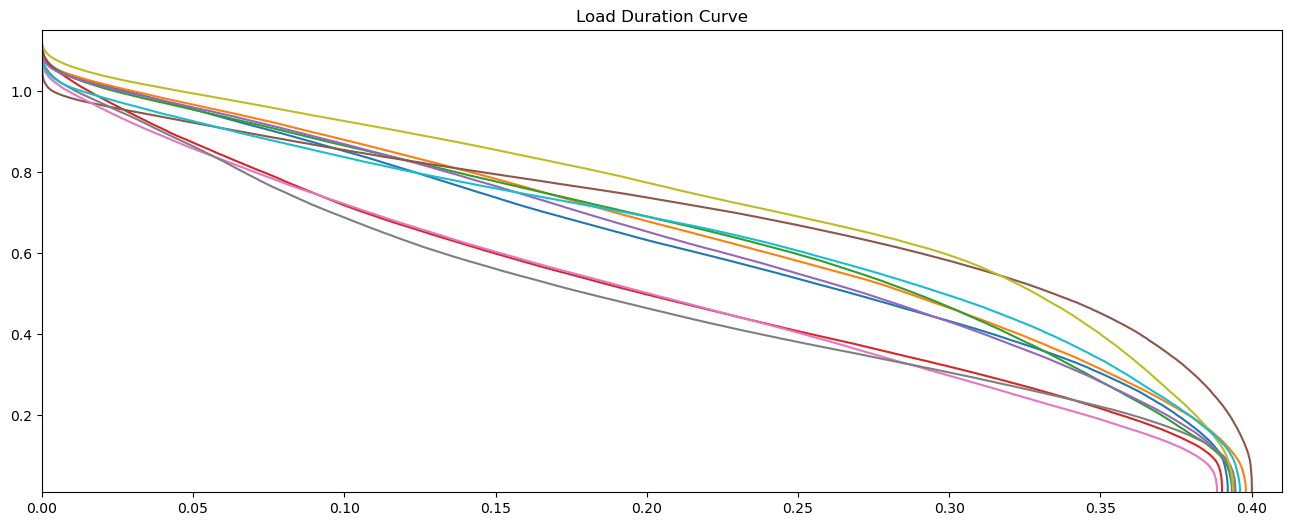

In [146]:
# It is helpful to first look at the load duration durve to assess these results

fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    
    
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    
    ax.plot(np.linspace(0, 1, len(data_filled)), np.sort(data_filled)[::-1])
    ax.set_xlim(0, 0.41)
    ax.set_ylim(0.01, 1.15)
    ax.set_title('Load Duration Curve')

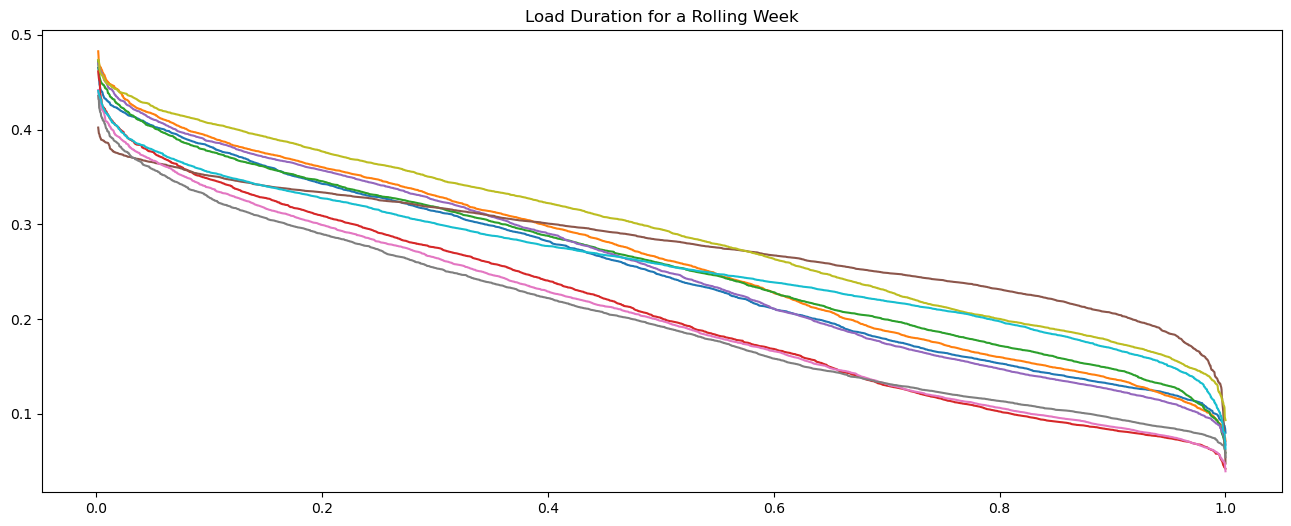

In [151]:
fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    
    
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    daily = data_filled.resample(time='1D').mean()
    rolling_week = daily.rolling(time=7, center=False).mean()
    
    ax.plot(np.linspace(0, 1, len(rolling_week)), np.sort(rolling_week)[::-1])
    ax.set_title('Load Duration for a Rolling Week')

### Weekly Droughts

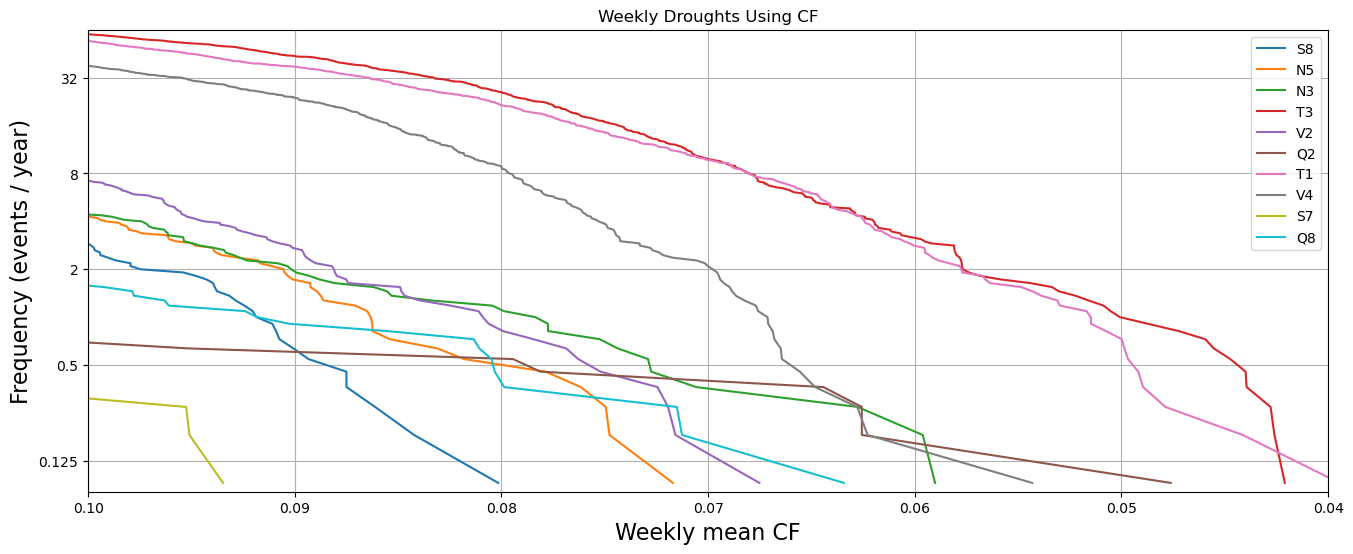

In [184]:
fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:

    data = ds.actual.sel(region=reg).copy()
    
    
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    daily = data_filled.resample(time='1D').mean()
    rolling_week = daily.rolling(time=7, center=False).mean()
    
    sorted_vals = np.sort(rolling_week)
    cdf = np.arange(1, len(sorted_vals)+1) / len(np.unique(ds.time.dt.year))
    
    ax.plot(sorted_vals, cdf, label = reg.data)
ax.set_xlim(0.1,0.04)
# ax.set_ylim(0,20)
ax.grid(True)
ax.set_xlabel('Weekly mean CF', fontsize=16)
ax.set_ylabel('Frequency (events / year)', fontsize=16)
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.set_yticks([0.125, 0.5, 2, 8, 32])
ax.set_ylim(0.08,64)
ax.set_title('Weekly Droughts Using CF', fontsize=20)

ax.legend()

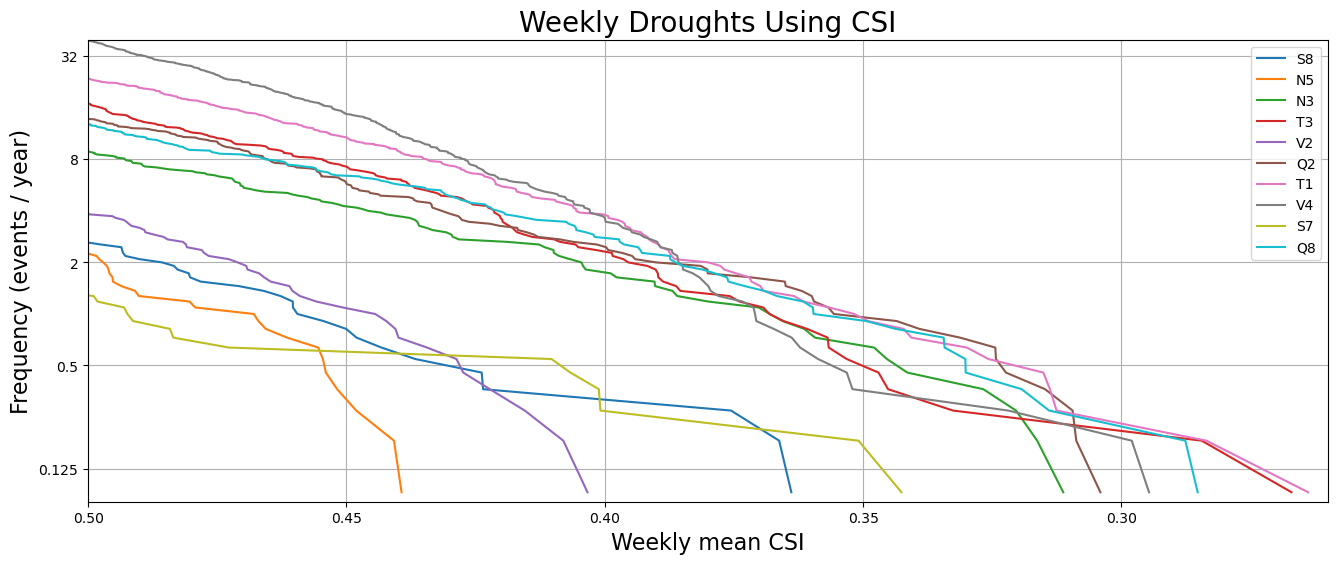

In [183]:
fig, ax = plt.subplots(figsize=(16,6))

for reg in ds.region:
    
    data = ds.sel(region=reg).copy()
    full_time = pd.date_range(start=ds.time.min().values,
                          end=ds.time.max().values,
                          freq='10min')
    data_filled = data.reindex(time=full_time).fillna(0)
    
    rolling_week = daily.rolling(time=7, center=False).mean()

    daily_actual = data_filled.actual.resample(time='1D').sum()
    daily_ideal = data_filled.ideal.resample(time='1D').sum()
    daily_CSI = daily_actual / daily_ideal

    rolling_week = daily_CSI.rolling(time=7, center=False).mean()
    
    sorted_vals = np.sort(rolling_week)
    cdf = np.arange(1, len(sorted_vals)+1) / len(np.unique(ds.time.dt.year))
    
    ax.plot(sorted_vals, cdf, label = reg.data)
ax.set_xlim(0.5,0.26)
ax.grid(True)
ax.set_xlabel('Weekly mean CSI', fontsize=16)
ax.set_ylabel('Frequency (events / year)', fontsize=16)
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.set_yticks([0.125, 0.5, 2, 8, 32])
ax.set_ylim(0.08,40)
ax.set_title('Weekly Droughts Using CSI', fontsize=20)

ax.legend()